## CoVaR (Conditional Value at Risk)

CoVaR is a VaR  (Value at Risk) of financial system conditional on an insitution being  in distress. A great first introduction to systemic risk is well explained [here](https://www.youtube.com/watch?v=UzW195qWHYg) from **LSE**!!! This concept is also introduced well in [this presentation slide](https://banknegaramy.sharepoint.com/:f:/r/sites/DSA/Shared%20Documents/Courses/SEACEN%20Analysis%20and%20Modelling%20of%20Macro-Financial%20Linkages/Session%2013%20-%20Systemic%20Risk%20Measurement?csf=1&web=1&e=gX1YyM) - you need access to DSA Course Materials folder to open this link. If you fancy to dive deep into the technical stuff, feel free to read the [original paper here](https://www.princeton.edu/~markus/research/papers/CoVaR).

## Systemic Risk components 

Unseen risk that is only visible when in crisis. Mainly, the risk was due to individual economic agent interacting in the market such that each decision may have pontentially an unseen impact to the overal financial system. Eventhough each individual agent acts rationally individually but if they act together, it can create a huge variation in the market, far away from the actual optimal situation. The component consists of:

1. the risk builds up in the backgroung during credit booms (hardly seen during good times)
2. In time of crisis, the **spillover effects** that amplifies the intertial adverse shocks are part of systemic problems. 

CoVaR quantifies the marginal risk contribution of an institution to the overall risk of the financial system. Basically finding the fraction for which an institution is the contributing engine to the financial system when in crisis. 

The **spillover effects** can be a direct link, through contractual links among financial institutions can be in the form of

1. common exposure market - selling off assets drive the asset value down so other economic agents who hold such assets are affected by the sell offs. 
2. Margin spiral - increase volatility tighten the margin gains. Hence encouring more agents to sell off their parts. 


### How to estimate it 
Let $ X $ be an institution, $ Y $ be a system, $ t $ time period

1. $ VAR^x $ of $ X $ institution (ex Maybank - stock return) during normal times by taking the 2nd quantile (Median) of the return. 
2. $ \overline {VAR^x} $ of $ X $ institution (ex Maybank - stock return) during distress time by taking the 0.05 quantile (5th percentile) of the return. 
3. Apply quantile regression based on the following spesifications
$$ Return_t^y = \alpha^{y|x} + \lambda^{y|x} Return_t^x + \epsilon_t^{y|x} $$ 
4. Calculate the systemic risk $\triangle CoVaR^{y|x}  $
$$ \triangle CoVaR^{y|x} = \lambda^{y|x} (\overline {VAR^x} - VAR^x ) $$

*full proof can be found in the original paper*


### Other applications of CoVaR
due to the generality proprety that CoVaR possesses, we can generalise it to apply on many other applications. 

1. Systemic risk in stock and bond markets, banking system, CDS, mutual fund industries etc
2. Estimate institution’s risk increases given that the whole financial system is in distress.
3. [Growth at risk - Adrian et al](https://economics.yale.edu/sites/default/files/tobias_adrian_metrics_seminar_102616.pdf)
4. Capital at risk

In [50]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import QuantileRegressor
import statsmodels.formula.api as smf

#Yahoo Finance API
from pandas_datareader import data as pdr
import yfinance as yf
import investpy as ip
yf.pdr_override()

In [51]:
#AMBANK, 1015
stock_name = ["MAYBANK", "PBBANK", "CIMB", "RHBBANK", "ABMB","AFFIN", "BIMB", "HLBANK" ,"HLFG"]
stock_list = ["1155", "1295", "1023", "1066", "2488", "5185", "5258", "5819", "1082"]

#save the bank name and its corresponding code in a dict
dict_stocks = {}
for stockName, code in zip(stock_name, stock_list):
    dict_stocks[str(code+".KL")]=stockName
stocks = [stock+".KL" for stock in stock_list]

#fetch data from yahoo finance
def getData(stocks, start, end, interval="d"):
    data = pdr.get_data_yahoo(stocks, start=start, end=end, interval=interval)
    close = data["Close"]
    close = close.dropna()
    returns = close.pct_change()
    return close, returns

In [5]:
endDate = dt.datetime(2022,6,27)
startDate = endDate - dt.timedelta(days=10*52*7+3)

ori_dt, returns = getData(stocks, start=startDate, end=endDate, interval="1wk")
returns.rename(columns=dict_stocks, inplace=True) #rename columns
returns.dropna(inplace=True) #drop first data point
returns.tail(10)

[*********************100%***********************]  9 of 9 completed


,CIMB,RHBBANK,HLFG,MAYBANK,PBBANK,ABMB,AFFIN,BIMB,HLBANK
Date,,,,,,,,,
2022-04-25,0.005803,0.046901,-0.010204,0.014541,-0.006356,-0.007874,-0.009434,-0.010239,-0.000952
2022-05-02,-0.015385,-0.028800,-0.015464,-0.007718,-0.021322,-0.034392,-0.009524,0.000000,-0.013346
2022-05-09,-0.015625,-0.004942,-0.011518,-0.004444,-0.013072,-0.013699,0.000000,0.024138,-0.001932
2022-05-16,-0.003968,-0.029801,0.032839,0.000000,-0.002208,-0.002778,0.043269,0.006734,0.020329
2022-05-23,0.005976,0.015358,-0.001026,0.003348,0.022124,-0.025070,0.004608,-0.010033,-0.003795
2022-05-30,0.009901,0.001681,0.010267,-0.012236,-0.008658,0.011429,0.000000,-0.023649,-0.001905
2022-06-06,-0.011765,-0.010067,-0.024390,-0.014640,-0.010917,0.011299,-0.091743,-0.017301,-0.007634
2022-06-13,-0.023810,-0.003390,-0.030208,0.014857,-0.008830,-0.050279,-0.040404,-0.031690,0.009615
2022-06-20,-0.004065,-0.037415,-0.012889,-0.031532,-0.013363,-0.029412,-0.010526,-0.036364,-0.040000


In [6]:
#fetch KLFI data from investing.com
search_result = ip.search_quotes(text='KLFI', products=['indices'], countries=['Malaysia'], n_results=1) 
klfi = search_result.retrieve_historical_data(from_date='06/07/2012',to_date='28/06/2022')
klfi = klfi.filter(items=ori_dt.index, axis=0)
klfi.rename(columns={"Close": "KLFI"}, inplace=True)
ori_dt =ori_dt.join(klfi["KLFI"])

#check for discrepancy 
print("missing values (Discrepancy) ", ori_dt.isnull().sum())
ori_dt = ori_dt.dropna()

#remove null values - need to recheck this
returns = ori_dt.pct_change()
returns.dropna(inplace=True)
returns.rename(columns=dict_stocks, inplace=True)

missing values (Discrepancy)  1023.KL     0
1066.KL     0
1082.KL     0
1155.KL     0
1295.KL     0
2488.KL     0
5185.KL     0
5258.KL     0
5819.KL     0
KLFI       48
dtype: int64


## VaR (Value at Risk) Function

In [7]:
def VaR(stocks, alpha=0.05):
    """ reads in a panda dataframe/series of returns
        output the percentile of the distibution at a givel alpha confidence interval
    """
    if isinstance(stocks, pd.Series) or isinstance(stocks, pd.DataFrame):
        return stocks.quantile(alpha)
    else:
        raise TypeError("Expected input to be panda dataframe or series")
        
print("Value at Risk during Distress     : ", VaR(returns))
print("-------------------------------------------------------------")
print("Value at Risk during Normal       : ", VaR(returns, alpha=0.5))

Value at Risk during Distress     :  CIMB      -0.054023
RHBBANK   -0.038956
HLFG      -0.044825
MAYBANK   -0.031277
PBBANK    -0.033043
ABMB      -0.047729
AFFIN     -0.036534
BIMB      -0.040769
HLBANK    -0.028322
KLFI      -0.025940
Name: 0.05, dtype: float64
-------------------------------------------------------------
Value at Risk during Normal       :  CIMB       0.000000
RHBBANK    0.000000
HLFG       0.000000
MAYBANK    0.000000
PBBANK     0.000000
ABMB      -0.002273
AFFIN     -0.002631
BIMB       0.000000
HLBANK     0.000000
KLFI      -0.000969
Name: 0.5, dtype: float64


# CoVaR
Quantile regression can be run on two libraries, **stastmodels & sklearn** and here we show both implementations.

## StastsModels Library

In [8]:
def stats_quanreg(X, Y, data, alpha, details=False):
    variables = Y + "~" + X
    #fit quantile reg model
    quanStats = smf.quantreg(variables, returns).fit(q=alpha)

    #view model summary
    lambdaCoeff = quanStats.params[X]

    varNormal = VaR(returns, alpha=0.5)[X]*100
    varDistress = VaR(returns)[X]*100

    covar = lambdaCoeff * (varNormal - varDistress) 
    
    if details:
        print( X+"'s contributions to "+ Y + "'s systemic risk:   ", round(covar, 3))
        print("==============================================================================")
        print(quanStats.summary())
    
    return round(covar, 2)
    
stats_quanreg("MAYBANK", "PBBANK", returns, alpha=0.05)

2.05

## Sklearn Library

In [9]:
def sklearn_quanreg(X, Y, data, quantile):
    x = data[X].values.reshape(-1,1)
    Y = data[Y]
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    qr.fit(x, Y)
    
    lambdaCoeff = qr.coef_[0] #get the parameter coeff

    varNormal = VaR(returns, alpha=0.5)[X]*100
    varDistress = VaR(returns)[X]*100

    covar = lambdaCoeff * (varNormal - varDistress) 
    return round(covar, 2)

sklearn_quanreg("MAYBANK", "PBBANK", returns, quantile=0.05)

2.05

In [10]:
#check if the outputs are the same
sklearn_quanreg("MAYBANK", "PBBANK", returns, quantile=0.05) == stats_quanreg("MAYBANK", "PBBANK", returns, alpha=0.05)

True

## CoVaR Analysis



In [17]:
#These iterations may take quite sometime to run. 
stock_name.append("KLFI")
covar_matrix_sklearn = {}
for stock_i in stock_name:
    covar_i = [sklearn_quanreg(X=stock_j, Y=stock_i, data=returns, quantile=0.05) for stock_j in stock_name]
    covar_matrix_sklearn[stock_i] = covar_i

covar_matrix_sklearn = pd.DataFrame(covar_matrix_sklearn)

C:\Anaconda\lib\site-packages\sklearn\linear_model\_quantile.py:268: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 1: Iteration limit reached.
Result message of linprog:
The iteration limit was reached before the algorithm converged.
  warnings.warn(


In [49]:
covar_matrix_sklearn

,MAYBANK,PBBANK,CIMB,RHBBANK,ABMB,AFFIN,BIMB,HLBANK,HLFG,KLFI
MAYBANK,3.13,2.05,3.23,2.42,2.88,2.06,0.76,1.67,1.47,1.14
PBBANK,1.31,3.30,1.11,1.46,2.09,1.82,1.24,1.19,1.83,0.80
CIMB,2.29,2.67,5.40,2.24,3.36,2.25,1.78,2.14,2.68,1.22
RHBBANK,1.29,1.83,1.84,3.90,2.67,2.06,0.95,1.53,2.11,0.50
ABMB,1.17,1.82,1.54,1.66,4.55,2.36,1.18,1.81,2.19,0.72
AFFIN,1.26,1.19,1.65,1.48,1.88,3.39,0.64,1.00,1.12,0.68
BIMB,1.10,0.85,1.52,1.14,0.83,1.68,4.08,0.88,0.82,0.43
HLBANK,1.29,1.70,0.71,1.24,1.84,1.43,1.10,2.83,2.28,0.45
HLFG,1.50,1.69,1.22,2.04,1.84,2.03,0.77,1.98,4.48,0.31
KLFI,0.93,0.71,0.99,0.87,0.98,1.45,0.88,0.44,0.80,2.50


Text(114.0, 0.5, 'Institutional Contributions')

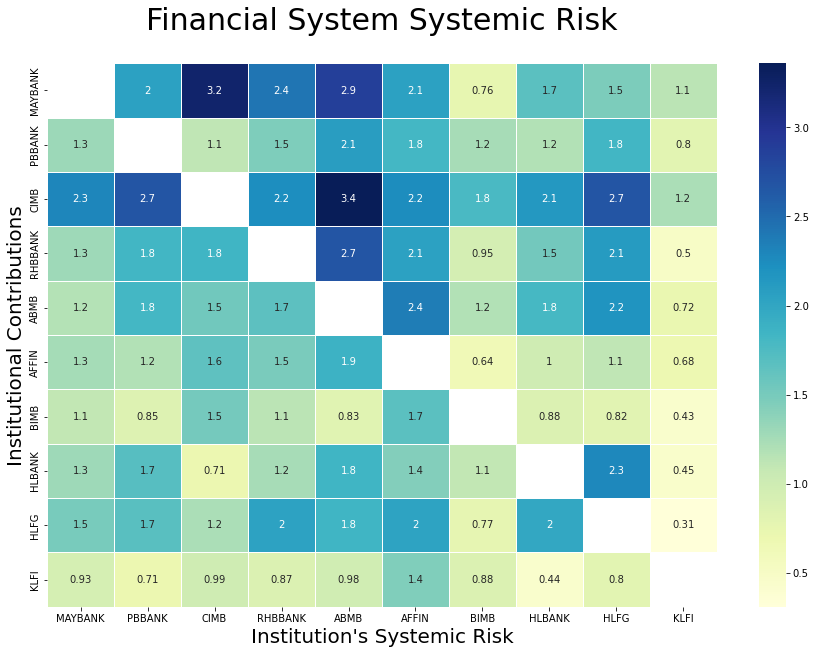

In [20]:
#stock_name.remove("KLFI")
covar_matrix_sklearn.index = stock_name

#one quantiles regression on sklearn did not converge but surprisingly they do on statsmodels
covar_matrix_sklearn["ABMB"]["HLBANK"] = stats_quanreg("HLFG", "ABMB", returns, alpha=0.05)

#create a diagonal mask
mask = np.zeros_like(covar_matrix_sklearn)
mask[np.diag_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,10))         
sns.heatmap(covar_matrix_sklearn,linewidths=.5, cmap="YlGnBu", annot=True, mask=mask, ax=ax)

plt.title('Financial System Systemic Risk', fontsize=30, y=1.05)
plt.xlabel("Institution's Systemic Risk", fontsize=20)
plt.ylabel("Institutional Contributions", fontsize=20)

In [25]:
covar_matrix_stats = {}
for stock_i in stock_name:
    covar_i = [stats_quanreg(X=stock_j, Y=stock_i, data=returns, alpha=0.05) for stock_j in stock_name]
    covar_matrix_stats[stock_i] = covar_i

covar_matrix_stats = pd.DataFrame(covar_matrix_stats)

C:\Anaconda\lib\site-packages\statsmodels\regression\quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
C:\Anaconda\lib\site-packages\statsmodels\regression\quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
C:\Anaconda\lib\site-packages\statsmodels\regression\quantile_regression.py:203: RuntimeWarning: invalid value encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
C:\Anaconda\lib\site-packages\statsmodels\regression\quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
C:\Anaconda\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [26]:
covar_matrix_stats

,MAYBANK,PBBANK,CIMB,RHBBANK,ABMB,AFFIN,BIMB,HLBANK,HLFG,KLFI
0,3.13,2.05,3.23,2.42,2.88,2.06,0.76,1.67,1.47,1.14
1,1.31,3.30,1.11,1.46,2.09,1.82,1.24,1.19,1.83,0.80
2,2.29,2.67,5.40,2.24,3.36,2.25,1.78,2.14,2.68,1.22
3,1.29,1.83,1.84,3.90,2.64,2.06,0.95,1.53,2.11,0.50
4,1.17,1.82,1.54,1.66,4.55,2.36,1.18,1.81,2.19,0.72
5,1.26,1.19,1.65,1.48,1.88,3.39,0.64,1.00,1.12,0.68
6,1.10,0.84,1.52,1.14,0.83,1.68,4.08,0.88,0.82,0.43
7,1.29,1.70,0.71,1.24,2.12,1.43,1.10,2.83,2.28,0.45
8,1.50,1.69,1.17,2.04,1.84,2.03,0.77,1.98,4.48,0.31
9,0.93,0.71,0.99,0.87,0.98,1.45,0.88,0.44,0.80,2.50


Text(114.0, 0.5, 'Institutional Contributions')

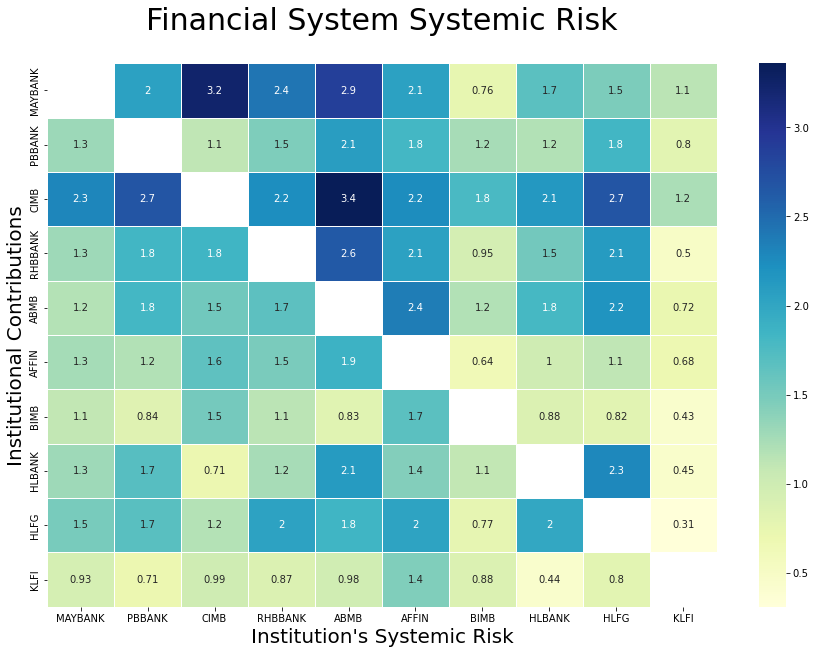

In [27]:
covar_matrix_stats.index = stock_name

#create a diagonal mask
mask = np.zeros_like(covar_matrix_sklearn)
mask[np.diag_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,10))         
sns.heatmap(covar_matrix_stats,linewidths=.5, cmap="YlGnBu", annot=True, mask=mask, ax=ax)

plt.title('Financial System Systemic Risk', fontsize=30, y=1.05)
plt.xlabel("Institution's Systemic Risk", fontsize=20)
plt.ylabel("Institutional Contributions", fontsize=20)

In [28]:
covar_matrix_stats == covar_matrix_sklearn

,MAYBANK,PBBANK,CIMB,RHBBANK,ABMB,AFFIN,BIMB,HLBANK,HLFG,KLFI
MAYBANK,True,True,True,True,True,True,True,True,True,True
PBBANK,True,True,True,True,True,True,True,True,True,True
CIMB,True,True,True,True,True,True,True,True,True,True
RHBBANK,True,True,True,True,False,True,True,True,True,True
ABMB,True,True,True,True,True,True,True,True,True,True
AFFIN,True,True,True,True,True,True,True,True,True,True
BIMB,True,False,True,True,True,True,True,True,True,True
HLBANK,True,True,True,True,False,True,True,True,True,True
HLFG,True,True,False,True,True,True,True,True,True,True
KLFI,True,True,True,True,True,True,True,True,True,True


<AxesSubplot:>

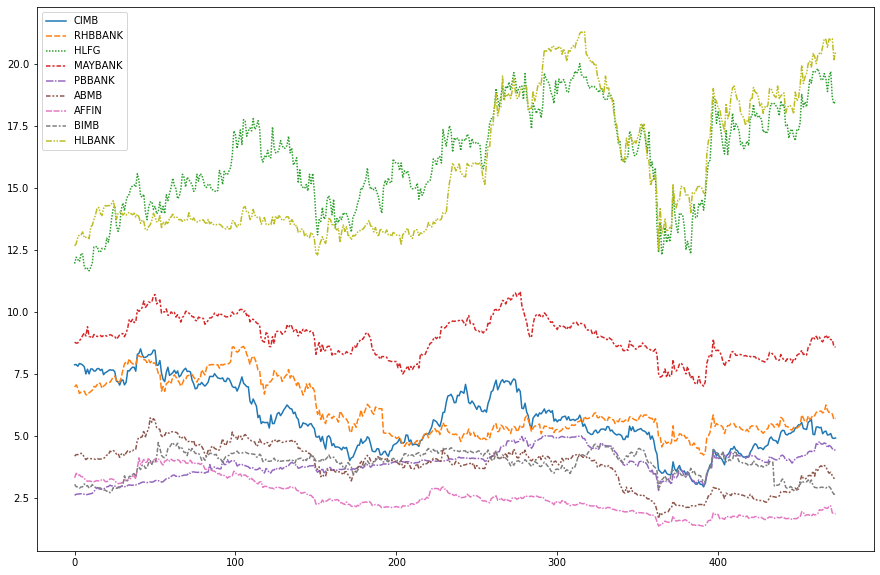

In [29]:
closePrice = ori_dt.copy()
closePrice.drop(columns = "KLFI", inplace=True)
closePrice = closePrice.rename(columns = dict_stocks)
index_reset = closePrice.reset_index().dropna()

fig, ax1 = plt.subplots(figsize=(15,10)) 
sns.lineplot(data=index_reset, ax=ax1)

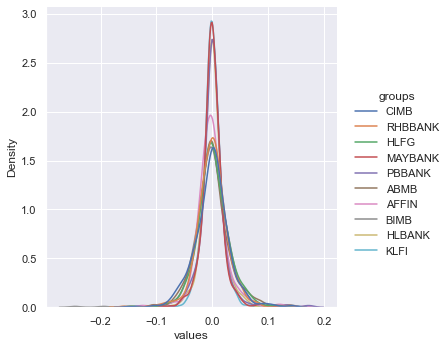

In [30]:
stack_df = returns.stack().reset_index().rename(columns={'level_1': 'groups', 0: 'values'})

sns.set(rc = {'figure.figsize':(15,10)})
sns.displot(x='values', data=stack_df, hue='groups',  kind="kde", fill=False)

In [36]:
covar_var.corr()

,VaR,CoVaR
VaR,1.000000,0.348354
CoVaR,0.348354,1.000000


Text(0.5, 0, 'VaR')

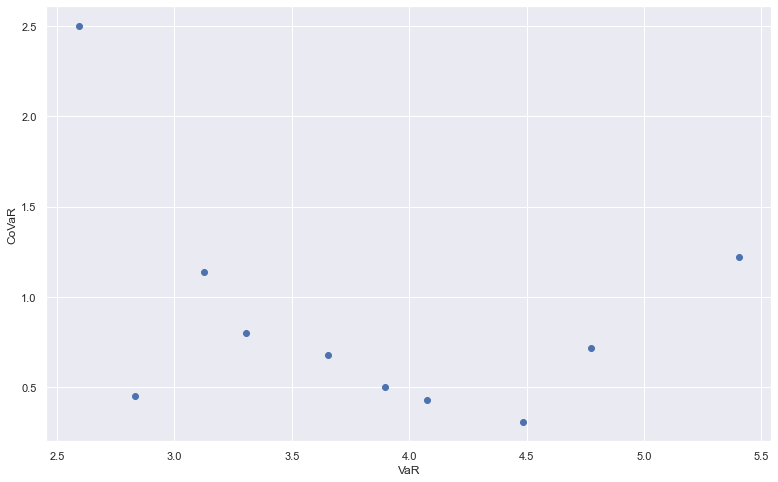

In [31]:
#create a dataframe
var_return = VaR(returns)
covar_return = covar_matrix_stats["KLFI"]
covar_var = pd.merge(var_return, covar_return, right_index=True, left_index=True)
covar_var.rename(columns={0.05: "VaR", "KLFI": "CoVaR"}, inplace=True)

sns.set(rc = {'figure.figsize':(13,8)})
plt.scatter(x=covar_var["VaR"]*-100, y=covar_var["CoVaR"])
plt.ylabel("CoVaR")
plt.xlabel("VaR")
corr = np.corr()

<AxesSubplot:xlabel='Date', ylabel='KLFI'>

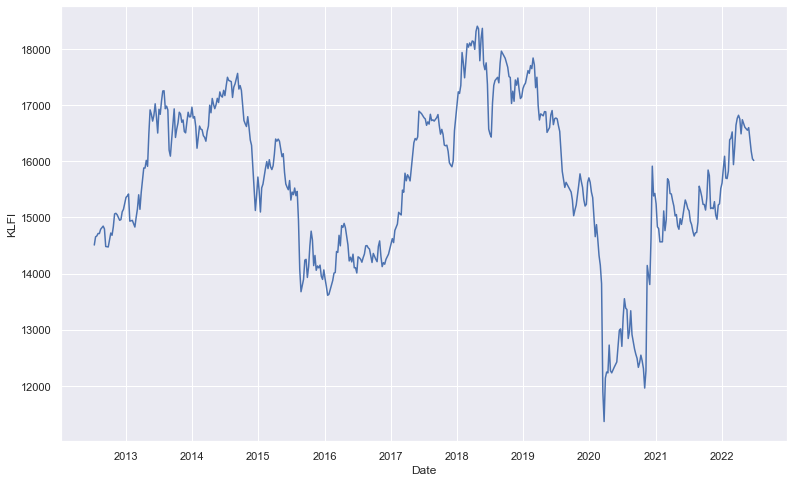

In [58]:
sns.lineplot(x= ori_dt.index, y=ori_dt["KLFI"])